# 1.4d: Distance Control (Uniform)

This notebook establishes a baseline by computing pairwise distances for uniformly random points in the same spatial region.

## The Question

We saw striking structure in the pairwise distance distribution (1.4c):
- 651k pairs at exact distance = 0 (duplicates)
- Discrete peaks at ~1e-5 scale
- Hierarchical structure with multiple "preferred" distances

But **what should we expect?** What does the pairwise distance distribution look like for **random points** in the same region?

## Method

We'll:
1. Generate 2,000 points uniformly distributed in the same (lat, lon, r) bounding box
2. Convert to Cartesian coordinates (using same PCA basis)
3. Compute pairwise distances
4. Plot histogram for comparison

In high-dimensional spaces, random points exhibit **concentration of measure**—almost all pairs are roughly the same distance apart, giving a smooth, unimodal distribution.

## Parameters

In [1]:
# Model (for PCA basis)
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis (must match 1.4a)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Bounding box (must match 1.4a)
LAT_MIN = -15
LAT_MAX = 5
LON_MIN = -10
LON_MAX = 20
R_MIN = 0.2
R_MAX = 0.5

# Random sampling
NUM_POINTS = 2000
RANDOM_SEED = 42

# Visualization
HIST_BINS = 100
FIGSIZE = (12, 6)
DPI = 200

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Detect Device

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load W and Compute PCA Basis

We need the same PCA basis to convert our random points to Cartesian coordinates.

In [4]:
# Load W
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32)
N, d = W.shape

print(f"Loaded W: {W.shape}")

Loaded W: torch.Size([151936, 2560])


In [5]:
# PCA
print("Computing PCA...")
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / N
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
print("✓ PCA computed")

Computing PCA...
✓ PCA computed


In [6]:
# Define basis
def get_pc_vector(pcs, index):
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"Spherical basis defined (North: PC{NORTH_PC}, Meridian: PC{MERIDIAN_PC}, Equinox: PC{EQUINOX_PC})")

Spherical basis defined (North: PC2, Meridian: PC1, Equinox: PC3)


## Generate Random Points in Spherical Coordinates

In [7]:
print(f"Generating {NUM_POINTS:,} random points...\n")

# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Sample uniformly in bounding box
lat_random = torch.rand(NUM_POINTS) * (LAT_MAX - LAT_MIN) + LAT_MIN  # degrees
lon_random = torch.rand(NUM_POINTS) * (LON_MAX - LON_MIN) + LON_MIN  # degrees
r_random = torch.rand(NUM_POINTS) * (R_MAX - R_MIN) + R_MIN

print(f"Sampled coordinates:")
print(f"  Latitude: [{lat_random.min():.2f}°, {lat_random.max():.2f}°]")
print(f"  Longitude: [{lon_random.min():.2f}°, {lon_random.max():.2f}°]")
print(f"  Radius: [{r_random.min():.4f}, {r_random.max():.4f}]")

Generating 2,000 random points...

Sampled coordinates:
  Latitude: [-14.95°, 5.00°]
  Longitude: [-9.95°, 19.97°]
  Radius: [0.2003, 0.4997]


## Convert to Cartesian Coordinates

In [8]:
print("\nConverting to Cartesian coordinates...\n")

# Convert to radians
lat_rad = torch.deg2rad(lat_random)
lon_rad = torch.deg2rad(lon_random)

# Spherical to Cartesian (in PCA basis)
x = r_random * torch.cos(lat_rad) * torch.cos(lon_rad)
y = r_random * torch.cos(lat_rad) * torch.sin(lon_rad)
z = r_random * torch.sin(lat_rad)

# Convert from PCA basis to original d-dimensional space
# Each point is: x*meridian + y*equinox + z*north
random_vecs = (x.unsqueeze(1) * meridian.unsqueeze(0) + 
               y.unsqueeze(1) * equinox.unsqueeze(0) + 
               z.unsqueeze(1) * north.unsqueeze(0))

print(f"Random vectors: {random_vecs.shape}")
print(f"  {NUM_POINTS:,} points")
print(f"  {d:,} dimensions")

# Verify norms
norms = torch.linalg.vector_norm(random_vecs, ord=2, dim=1)
print(f"\nVerifying norms:")
print(f"  Min: {norms.min():.4f}")
print(f"  Max: {norms.max():.4f}")
print(f"  Mean: {norms.mean():.4f}")


Converting to Cartesian coordinates...

Random vectors: torch.Size([2000, 2560])
  2,000 points
  2,560 dimensions

Verifying norms:
  Min: 0.2003
  Max: 0.4997
  Mean: 0.3526


## Compute Pairwise Distances

In [9]:
print("\nComputing pairwise distances...\n")

# Move to device for computation
random_vecs_device = random_vecs.to(device)

# Compute distances (all at once, NUM_POINTS is small enough)
with torch.no_grad():
    dists = torch.cdist(random_vecs_device, random_vecs_device).cpu()

print(f"✓ Distance matrix computed")
print(f"  Shape: {dists.shape}")

# Extract upper triangle
upper_tri_mask = torch.triu(torch.ones_like(dists, dtype=torch.bool), diagonal=1)
dists_upper = dists[upper_tri_mask]

print(f"\nUpper triangle:")
print(f"  Number of pairs: {len(dists_upper):,}")


Computing pairwise distances...

✓ Distance matrix computed
  Shape: torch.Size([2000, 2000])

Upper triangle:
  Number of pairs: 1,999,000


## Distance Statistics

In [10]:
print(f"\nDistance statistics:\n")

# Convert to numpy for stats
dists_np = dists_upper.numpy()

# Basic stats
print(f"  Min:     {dists_np.min():.10f}")
print(f"  Max:     {dists_np.max():.10f}")
print(f"  Mean:    {dists_np.mean():.10f}")
print(f"  Median:  {np.median(dists_np):.10f}")
print(f"  Std:     {dists_np.std():.10f}")
print()

# Exact zeros
n_zeros = (dists_upper == 0).sum().item()
print(f"Exact zeros: {n_zeros:,}")
if n_zeros > 0:
    print(f"  ⚠️  Warning: Found duplicate random vectors!")
else:
    print(f"  ✓ No duplicates (as expected for random points)")


Distance statistics:

  Min:     0.0007221777
  Max:     0.3406682909
  Mean:    0.1392466575
  Median:  0.1333741546
  Std:     0.0628014281

Exact zeros: 0
  ✓ No duplicates (as expected for random points)


## Distance Distribution Histogram


Creating histogram...



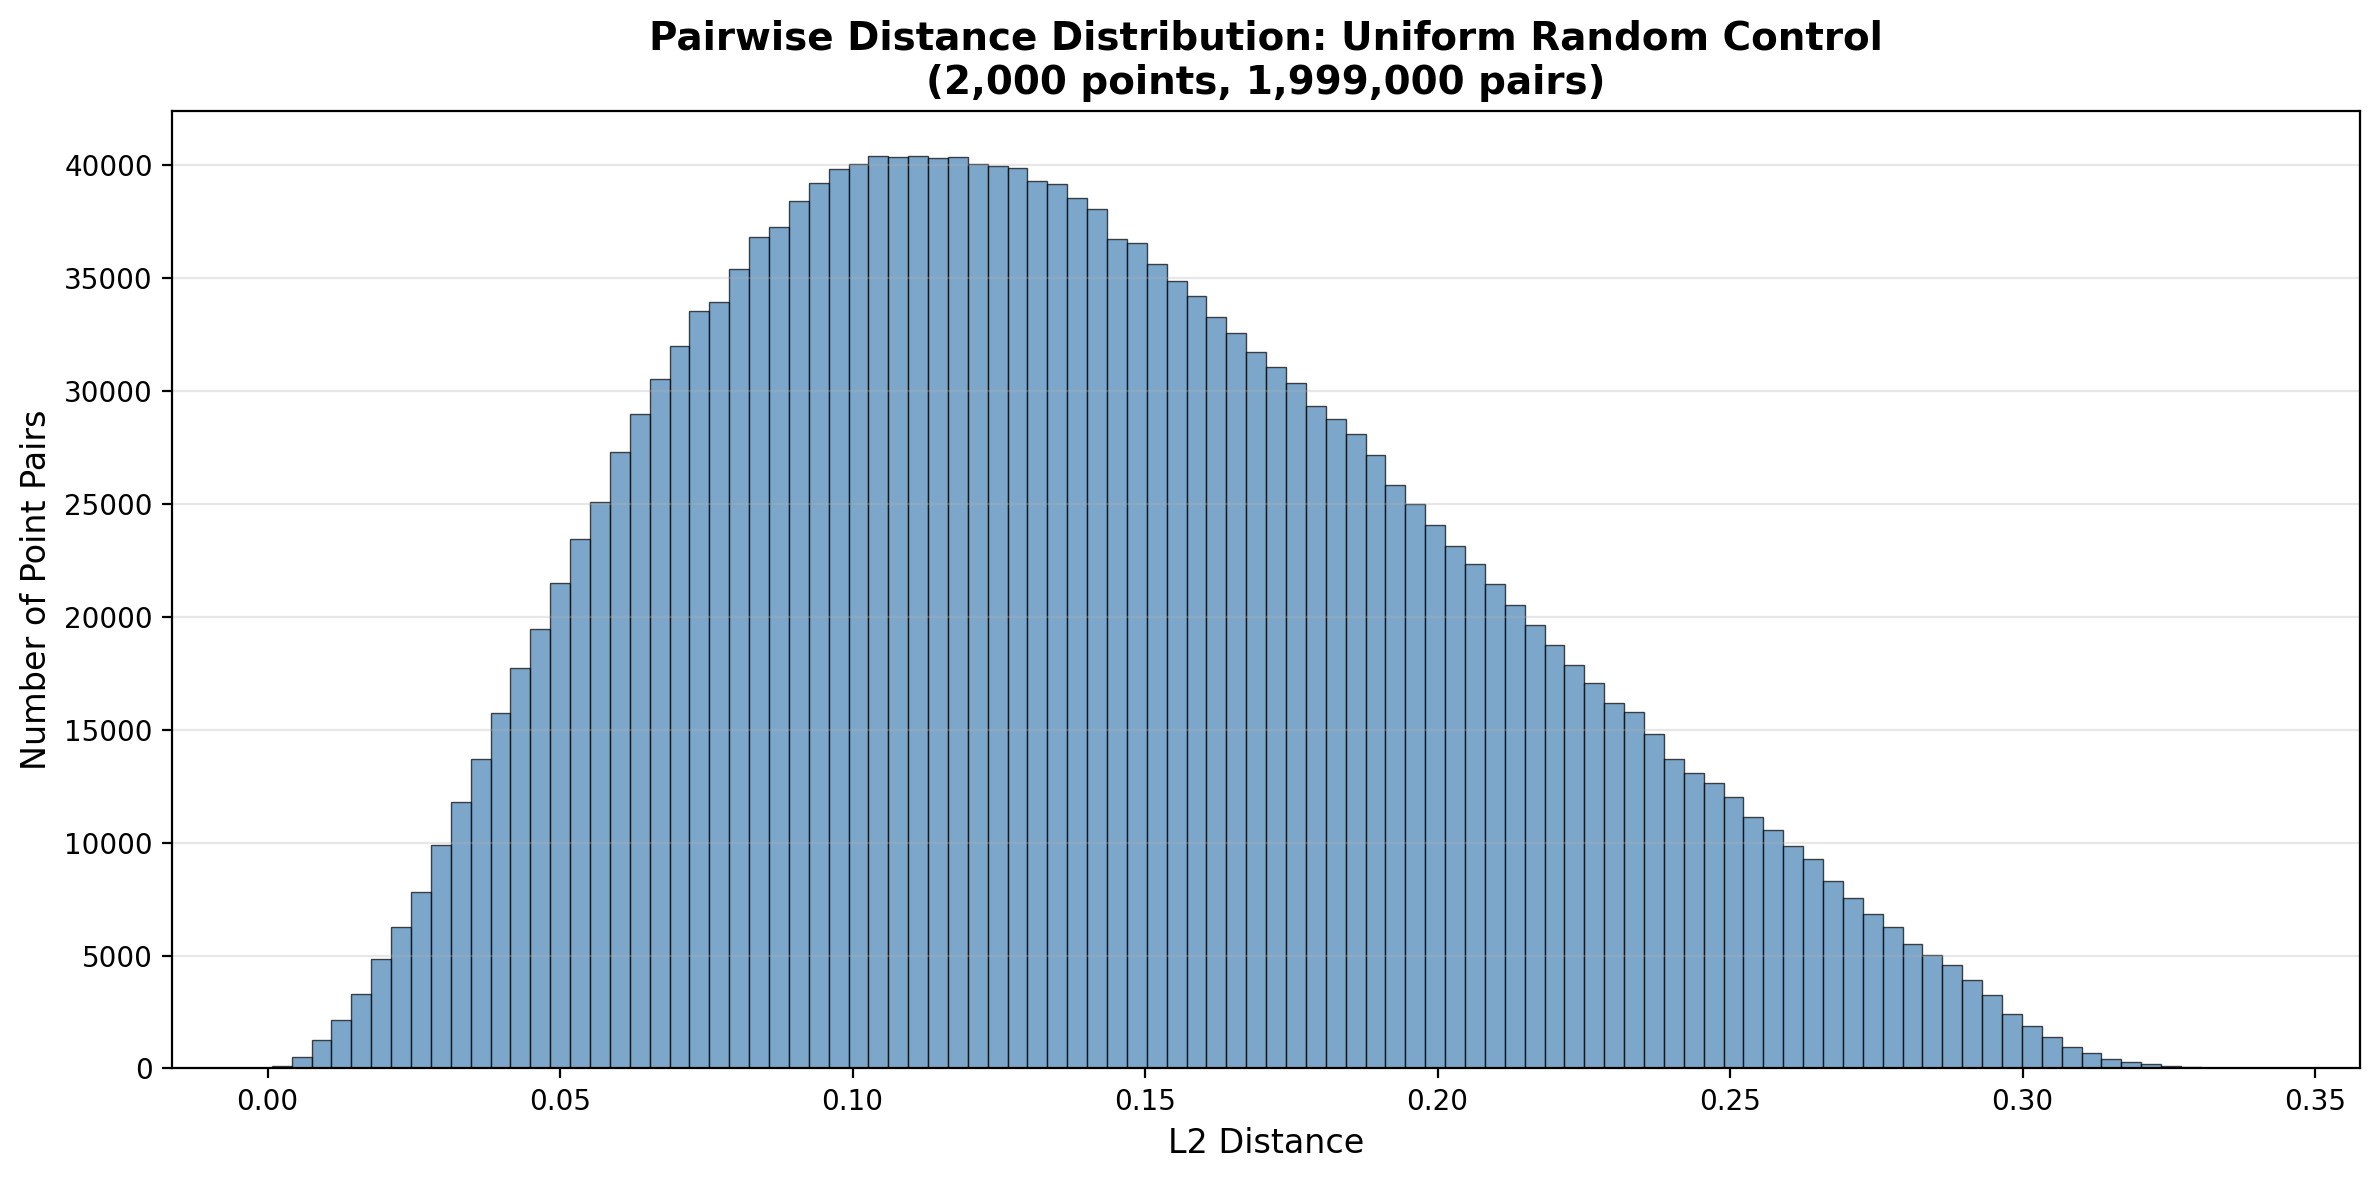

✓ Histogram complete


In [11]:
print(f"\nCreating histogram...\n")

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Histogram
ax.hist(dists_np, bins=HIST_BINS, color='steelblue', alpha=0.7, 
        edgecolor='black', linewidth=0.5)

# Formatting
ax.set_xlabel('L2 Distance', fontsize=12)
ax.set_ylabel('Number of Point Pairs', fontsize=12)
ax.set_title(f'Pairwise Distance Distribution: Uniform Random Control\n({NUM_POINTS:,} points, {len(dists_upper):,} pairs)',
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Histogram complete")

## Observations

For uniformly distributed random points in high-dimensional space, we expect:

- **Smooth, unimodal distribution**: Single peak, no discrete structure
- **Concentration of measure**: Most pairs at similar distances (narrow spread)
- **No exact zeros**: Duplicates have probability ~0
- **No discrete spikes**: No "preferred" distances

Compare this to the real data (1.4c):
- Real data has 651k pairs at exact distance = 0
- Real data has discrete peaks at specific distances (~1e-5 scale)
- Real data shows hierarchical structure with gaps

**Conclusion**: The real token distribution is fundamentally non-random. The discrete structure cannot be explained by chance.